# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = '/home/thunderbolt/cifar/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 100 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength
print (X_train_feats.shape)

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None
maxacc = 0

best_p = None
for I in learning_rates:
    for J in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_val_feats, y_val, learning_rate=I, reg=J,
                      num_iters=500, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(I,J)] = (train_acc,val_acc)
        if maxacc < val_acc:
            maxacc = val_acc
            best_val = val_acc
            best_svm = svm
            best_p = (I,J)
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

(49000, 245)
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.085429 val accuracy: 0.088000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.086898 val accuracy: 0.088000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.100980 val accuracy: 0.082000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.102184 val accuracy: 0.105000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.095122 val accuracy: 0.095000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.359306 val accuracy: 0.488000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.110163 val accuracy: 0.124000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.361347 val accuracy: 0.496000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.348837 val accuracy: 0.483000
best validation accuracy achieved during cross-validation: 0.496000


In [9]:
# Evaluate your trained SVM on the test set


svm = LinearSVM()
print (best_p)
loss_hist = svm.train(X_train_feats, y_train, learning_rate=best_p[0], reg=1e5,
              num_iters=5000, verbose=True)
y_test_pred = svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

(1e-07, 500000.0)
iteration 0 / 5000: loss 261.759082
iteration 100 / 5000: loss 101.750765
iteration 200 / 5000: loss 43.049626
iteration 300 / 5000: loss 21.499236
iteration 400 / 5000: loss 13.589647
iteration 500 / 5000: loss 10.686490
iteration 600 / 5000: loss 9.619719
iteration 700 / 5000: loss 9.229110
iteration 800 / 5000: loss 9.085994
iteration 900 / 5000: loss 9.032747
iteration 1000 / 5000: loss 9.013321
iteration 1100 / 5000: loss 9.006162
iteration 1200 / 5000: loss 9.003593
iteration 1300 / 5000: loss 9.002592
iteration 1400 / 5000: loss 9.002240
iteration 1500 / 5000: loss 9.002022
iteration 1600 / 5000: loss 9.001825
iteration 1700 / 5000: loss 9.001711
iteration 1800 / 5000: loss 9.002003
iteration 1900 / 5000: loss 9.002042
iteration 2000 / 5000: loss 9.002213
iteration 2100 / 5000: loss 9.001994
iteration 2200 / 5000: loss 9.001889
iteration 2300 / 5000: loss 9.002000
iteration 2400 / 5000: loss 9.001695
iteration 2500 / 5000: loss 9.001746
iteration 2600 / 5000: l

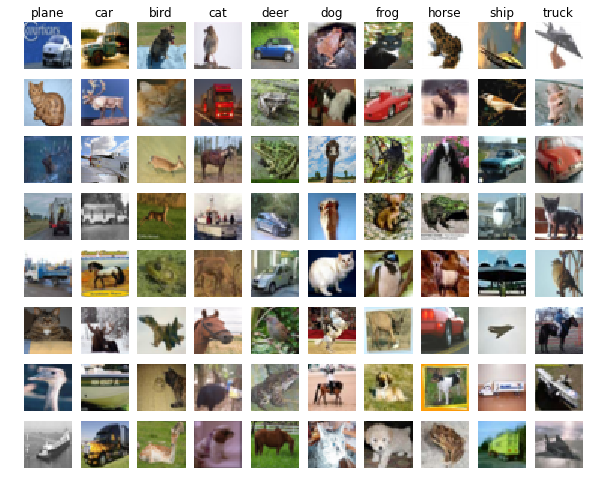

In [21]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [17]:
print(X_train_feats.shape)

(49000, 245)


In [20]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None
maxAcc = 0
results ={}
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for I in range(50):
    lr = np.random.uniform(0,2)
    re = np.random.uniform(1e-7,5e-7)
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=500, batch_size=100,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=re, verbose=True)
    train_acc = (net.predict(X_train_feats) == y_train).mean()
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    results[(lr,re)] = (train_acc,val_acc)
    if maxAcc <= val_acc:
        maxAcc = val_acc
        best_net = net
    print(str(I) + ' / 100 Validation accuracy: '+str( val_acc)+' lr ='+str(lr) +' re = '+str(re))

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 500: loss 2.302585
iteration 100 / 500: loss 1.857167
iteration 200 / 500: loss 1.704353
iteration 300 / 500: loss 1.839884
iteration 400 / 500: loss 1.871401
0 / 100 Validation accuracy: 0.429 lr =1.6985659732 re = 1.52975049688e-07
iteration 0 / 500: loss 2.302585
iteration 100 / 500: loss 1.724598
iteration 200 / 500: loss 1.992971
iteration 300 / 500: loss 1.453914
iteration 400 / 500: loss 1.567140
1 / 100 Validation accuracy: 0.465 lr =1.73830933598 re = 4.71473551001e-07
iteration 0 / 500: loss 2.302585
iteration 100 / 500: loss 1.506328
iteration 200 / 500: loss 1.707109
iteration 300 / 500: loss 1.434305
iteration 400 / 500: loss 1.801235
2 / 100 Validation accuracy: 0.459 lr =1.35533165431 re = 3.88144388141e-07
iteration 0 / 500: loss 2.302586
iteration 100 / 500: loss 1.924773
iteration 200 / 500: loss 1.822849
iteration 300 / 500: loss 1.732815
iteration 400 / 500: loss 1.570225
3 / 100 Validation accuracy: 0.397 lr =1.98323322885 re = 4.16605341737e-07
itera

iteration 100 / 500: loss 1.747718
iteration 200 / 500: loss 1.472285
iteration 300 / 500: loss 1.573601
iteration 400 / 500: loss 1.413758
33 / 100 Validation accuracy: 0.493 lr =1.09694322084 re = 2.75468395817e-07
iteration 0 / 500: loss 2.302585
iteration 100 / 500: loss 1.545136
iteration 200 / 500: loss 1.551045
iteration 300 / 500: loss 1.804020
iteration 400 / 500: loss 1.770343
34 / 100 Validation accuracy: 0.441 lr =1.76806069099 re = 3.76750166714e-07
iteration 0 / 500: loss 2.302585
iteration 100 / 500: loss 2.302551
iteration 200 / 500: loss 2.302441
iteration 300 / 500: loss 2.302680
iteration 400 / 500: loss 2.302598
35 / 100 Validation accuracy: 0.113 lr =0.00402065087551 re = 2.27004033594e-07
iteration 0 / 500: loss 2.302586
iteration 100 / 500: loss 1.411300
iteration 200 / 500: loss 1.320031
iteration 300 / 500: loss 1.502606
iteration 400 / 500: loss 1.297208
36 / 100 Validation accuracy: 0.482 lr =0.498577782594 re = 2.6896915089e-07
iteration 0 / 500: loss 2.3025

0.374891420734 2.02968316285e-07 (0.54791836734693877, 0.53400000000000003)


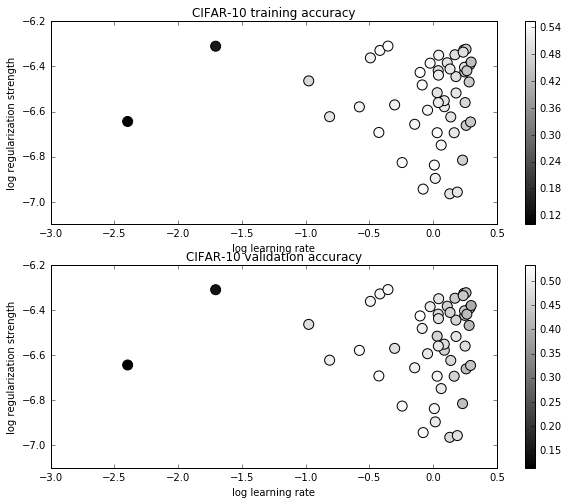

In [21]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

acc = 0
lr = re = None
for param in results:
    if results[param][1] > acc:
        acc = results[param][1]
        lr,re = param
        
        
print(lr,re,results[(lr,re)])
# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [23]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=3000, batch_size=100,
            learning_rate=0.374891420734, learning_rate_decay=0.95,
            reg=2.02968316285e-07, verbose=True)
test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

iteration 0 / 3000: loss 1.141464
iteration 100 / 3000: loss 0.845099
iteration 200 / 3000: loss 0.900685
iteration 300 / 3000: loss 0.845989
iteration 400 / 3000: loss 0.868343
iteration 500 / 3000: loss 0.862913
iteration 600 / 3000: loss 0.977600
iteration 700 / 3000: loss 0.709937
iteration 800 / 3000: loss 0.851323
iteration 900 / 3000: loss 0.810874
iteration 1000 / 3000: loss 0.793774
iteration 1100 / 3000: loss 0.679601
iteration 1200 / 3000: loss 0.630949
iteration 1300 / 3000: loss 0.818127
iteration 1400 / 3000: loss 0.865348
iteration 1500 / 3000: loss 0.585623
iteration 1600 / 3000: loss 0.914512
iteration 1700 / 3000: loss 0.798659
iteration 1800 / 3000: loss 0.563231
iteration 1900 / 3000: loss 0.808199
iteration 2000 / 3000: loss 0.565191
iteration 2100 / 3000: loss 0.657760
iteration 2200 / 3000: loss 0.705174
iteration 2300 / 3000: loss 0.565037
iteration 2400 / 3000: loss 0.654577
iteration 2500 / 3000: loss 0.672642
iteration 2600 / 3000: loss 0.612798
iteration 270

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!